# IBM Deep Learning and Reinforcement Learning
## Final Project

#### Hannah Reber, 2020

GitHub Repo: https://github.com/hannahaih/hundertotter_CNN_ImageStyleTransfer

Course: https://www.coursera.org/learn/deep-learning-reinforcement-learning

#### Based on this paper Image Style Transfer Using Convolutional Neural Networks by Leon A. Gatys et al.:
https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf




# Example B 

In [2]:
############################################################
################################# imports
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models
import os

In [9]:
################################################################
################################# IMPORT PRETRAINED MODEL: VGG    
vgg = models.vgg19(pretrained=True).features # get features-portion of VGG19 (needed for classifier portion)
for param in vgg.parameters():               # freeze all VGG parameters since we're only optimizing the target image
    param.requires_grad_(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
vgg.to(device)                               # move model to GPU

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
############################################################
################################# functions

# func to plot loss
def plotloss():
    plt.figure(figsize=(10,5))
    title = "LOSS EXAMPLE " + example_id
    plt.title(title)
    plt.plot(losses,label=example_id)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    picname = example_id+"_loss.jpg"
    plt.savefig(picname,dpi=300)


# func to load & preprocess pics
def load_image(img_path, max_size=400, shape=None):    
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape      
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
             # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)  
    return image

# func to un-normalize pics + conv fromm tensor to np.array
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

# func to get features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content representation
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():   # model._modules = dict holding each module in the model
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# func to get gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()           # get the batch_size, depth, height, and width of the Tensor
    tensor = tensor.view(d, h * w)       # reshape so we're multiplying the features for each channel
    gram = torch.mm(tensor, tensor.t())  # calculate the gram matrix  
    return gram

# Style B ➔ Content B

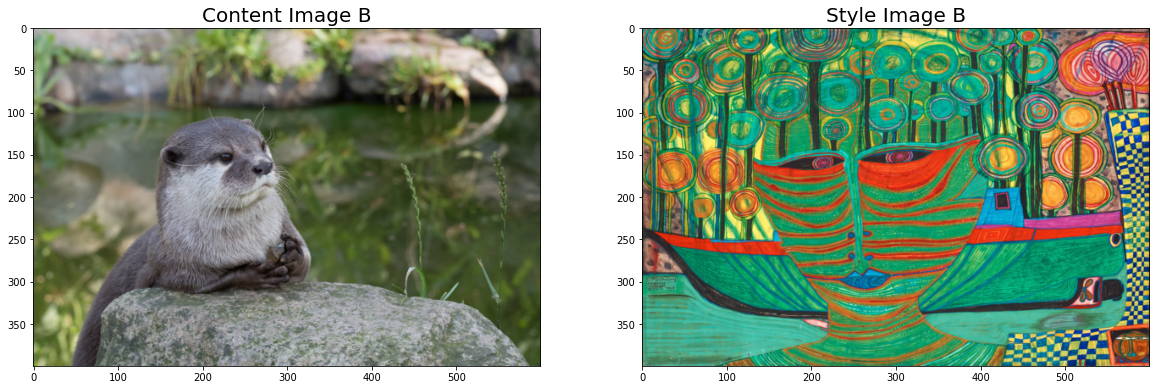

In [14]:
############################################################
################################# INPUT A 

# start with example A = input_a ➔ content_a
example_id = "B"

# def local paths
stylepath = os.getcwd() + '\\input_pics\\' + 'style_b.jpg'
contentpath = os.getcwd() + '\\input_pics\\' + 'content_b.jpg'
modelpath = "model_b.pt"

# initialize storages & session id (=number of notebook runs)
losses = []
output_pics = []
sessionnum = 0

content = load_image(contentpath).to(device)                         # load content + style pic
style = load_image(stylepath, shape=content.shape[-2:]).to(device)   # resize style to match content
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))               # display both pics
ax1.imshow(im_convert(content))                                    
ax1.set_title("Content Image "+example_id,fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image "+example_id, fontsize = 20)
plt.show()

In [15]:
# def features, grams, target
content_features = get_features(content, vgg)                  # get content and style features only once before training
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}    # gram matrices for style layers
target = content.clone().requires_grad_(True).to(device)                            # start with target = copy of content

In [16]:
style_weights = {'conv1_1': 1.,             # initialize weights for all layers EXCLUDING conv4_2
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1                          # alpha
style_weight = 1e9                          # beta
optimizer = optim.Adam([target], lr=0.003)  # optimizer

In [25]:
if sessionnum > 0:                          # load checkpoints if training is continued
    checkpoint = torch.load(modelpath)
    vgg.load_state_dict(checkpoint['vgg_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("session number: ",sessionnum)
    vgg.train()
picnum = 0
show_every = 500
num_epochs = 5000                           # set num of epochs and chehpoints for pics 

session number:  2


Epoch: 500 of 5000 	Total loss:  6715917824.0 	Pic name: B3pic1.jpg


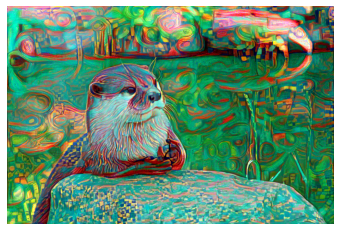

Epoch: 1000 of 5000 	Total loss:  4821275136.0 	Pic name: B3pic2.jpg


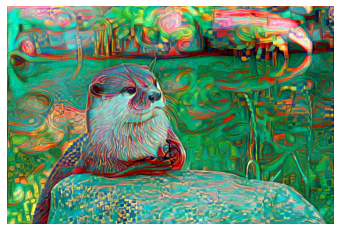

Epoch: 1500 of 5000 	Total loss:  3540188672.0 	Pic name: B3pic3.jpg


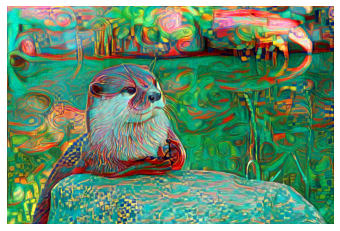

Epoch: 2000 of 5000 	Total loss:  2671070464.0 	Pic name: B3pic4.jpg


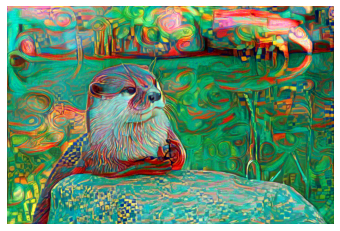

Epoch: 2500 of 5000 	Total loss:  2068503168.0 	Pic name: B3pic5.jpg


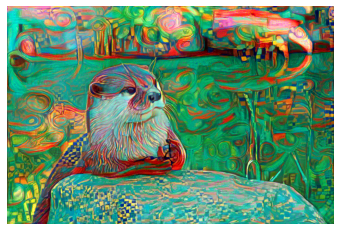

Epoch: 3000 of 5000 	Total loss:  1635795072.0 	Pic name: B3pic6.jpg


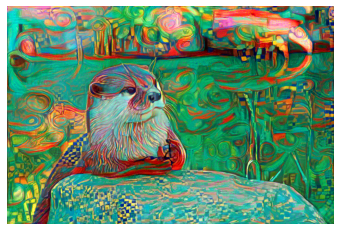

Epoch: 3500 of 5000 	Total loss:  1316170752.0 	Pic name: B3pic7.jpg


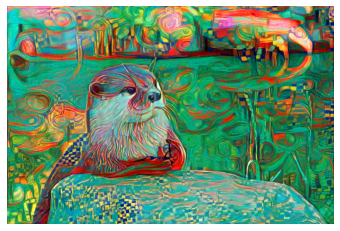

Epoch: 4000 of 5000 	Total loss:  1076911360.0 	Pic name: B3pic8.jpg


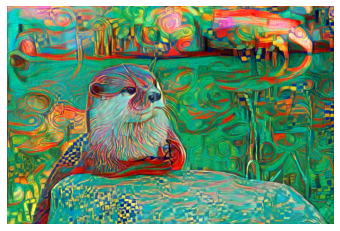

Epoch: 4500 of 5000 	Total loss:  894508160.0 	Pic name: B3pic9.jpg


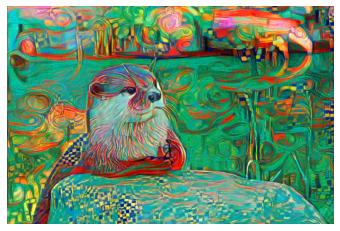

Epoch: 5000 of 5000 	Total loss:  754255040.0 	Pic name: B3pic10.jpg


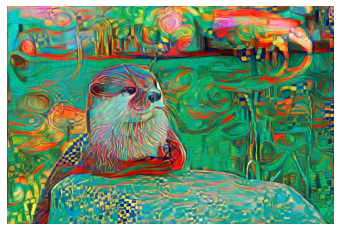

In [27]:
##########################################
################## TRAINING

sessionnum += 1                                                                  # update sessionnum with each run
for epoch in range(1, num_epochs+1):
    target_features = get_features(target, vgg)                          # get the features from your target image
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)        # content-loss
    style_loss = 0                                                                # initialize the style-loss to 0
    for layer in style_weights:                                 # then add to it for each layer's gram matrix loss
        target_feature = target_features[layer]              # get the "target" style representation for the layer
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]                                     # get the "style" style representation
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)  # style-loss of layer -> weighted
        style_loss += layer_style_loss / (d * h * w)                                            # added style-loss
    total_loss = content_weight * content_loss + style_weight * style_loss  # calculate total-loss
    losses.append(total_loss)                                                                        # save Losses
    optimizer.zero_grad()                                                                    # update target image
    total_loss.backward()
    optimizer.step()
    if  epoch % show_every == 0:                                                  # show intermediate pics + loss
        picnum += 1
        picname = example_id +str(sessionnum)+"pic" + str(picnum) + ".jpg"
        print("Epoch:", epoch,'of',num_epochs, '\tTotal loss: ', total_loss.item(), "\tPic name:",picname)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.savefig(picname,dpi=300)
        plt.show()

In [28]:
################################################################################################################################
torch.save({'vgg_state_dict': vgg.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},modelpath)

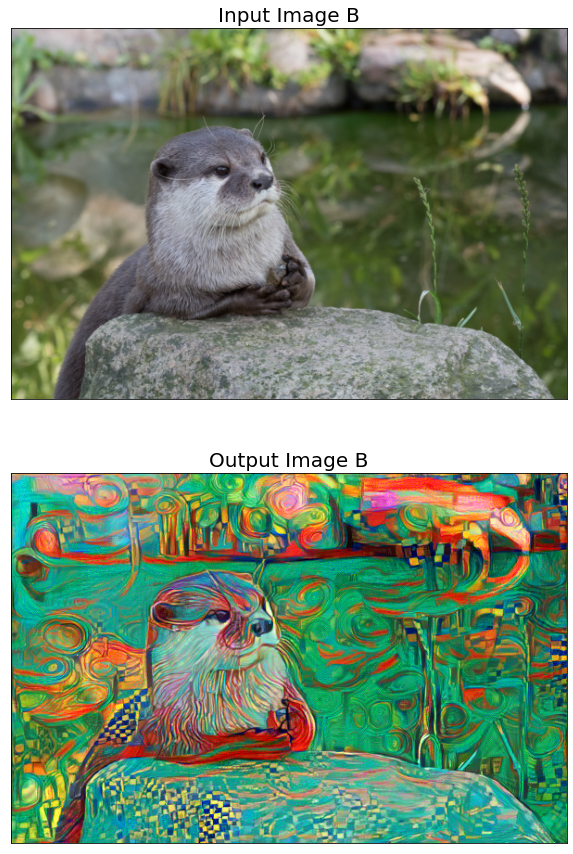

In [29]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Input Image "+ example_id, fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Output Image "+example_id, fontsize = 20)
ax1.grid(False)
ax2.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

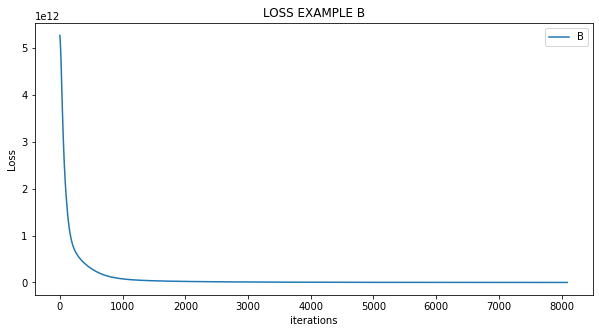

<Figure size 432x288 with 0 Axes>

In [30]:
plotloss()